# University Advancement, Donations, and Giving

This analysis uses data from a university's development department to understand more about the donors who have given money to the university. This type of analysis could help the development department answer some of the questions they might have about their work, such as: 
 
*   Who are our donors and how much do they give? 
*   What makes someone likely to be a donor? E.g. are people with particular majors particular likely to donate?
*   Did our outreach and campaigns have any effect on donations?
*   Which demographics should we target and when?
*   Which donors should we cultivate because they are or could become major benefactors?
*   Do we need to do more to engage with our alumni, or with any particular demographics within our alumni?

The original dataset can be downloaded [here](https://public.tableau.com/s/sites/default/files/media/advancement_donations_and_giving_demo.xls).









## Set up

### Install SQLITE

In [ ]:
!pip install -q pysqlite3-binary

     |████████████████████████████████| 5.3MB 4.0MB/s 


### Define functions

In [ ]:
# #@title Define functions
import tempfile
from urllib import request
import sqlite3
import pysqlite3

from typing import Dict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

#%load_ext google.colab.data_table

# Set float display options for pandas dataframes.
pd.options.display.float_format = "{:,.2f}".format

def excel_dataset_to_sqlite(url: str, database_name: str = ":memory:") -> sqlite3.Connection:
  """Downloads an excel dataset and loads it into an sqlite database."""

  # Download the data into a local variable.
  data = request.urlopen(url).read()

  # Write it out to afiles
  with tempfile.TemporaryFile() as fle:
    fle.write(data)

    # Read into pandas from excel file.
    data = pd.read_excel(fle, sheet_name=None)

  # Create a database.
  conn = pysqlite3.connect(database_name)

  # Loads data from pandas objects into individual tables.
  for (key, sheet) in data.items():
    sheet = sheet.where(pd.notnull(sheet), None)
    sheet.to_sql(key, conn)


  # Return database.
  return conn

## Prepare the data



### Import the dataset and create the database

In [ ]:
database = excel_dataset_to_sqlite("https://public.tableau.com/s/sites/default/files/media/advancement_donations_and_giving_demo.xls")

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


### View the table names to make sure the correct tables have been created

In [ ]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", database)

,name
0,GiftRecords
1,GraduationYear


### The table names look fine. But what about the column names?

The column names have spaces, which will make them annoying to work with in SQL queries. So, let's change the names to make queries easier.

In [ ]:
pd.read_sql("Select * From GiftRecords;", database)

,index,Allocation Subcategory,City,College,Gift Allocation,Gift Amount,Gift Date,Major,Prospect ID,State
0,0,College of Natural Science,Denver,College of Natural Science,Scholarship,"5,088.00",2010-07-28 00:00:00,Biological Science Interdepartmental,1000,CO
1,1,College of Natural Science,San Francisco,College of Social Science,Scholarship,"3,793.00",2010-09-10 00:00:00,Human Development and Family Studies,1001,CA
2,2,Minority Scholarship Fund,Los Angeles,College of Business,Scholarship,"2,952.00",2010-06-30 00:00:00,Accounting,1002,CA
3,3,College of Communication Arts and Sciences,Mesa,College of Natural Science,Scholarship,"2,872.00",2010-11-23 00:00:00,Mathematics,1003,AZ
4,4,Diversity Fund,West Valley City,College of Social Science,Endowment,"2,022.00",2010-10-10 00:00:00,Psychology,1004,UT
...,...,...,...,...,...,...,...,...,...,...
3908,3908,College of Arts and Sciences,Lexington,College of Engineering,Scholarship,936.00,2015-11-22 00:00:00,Environmental Engineering,3315,KY
3909,3909,Diversity Fund,New York,College of Natural Science,Endowment,"4,466.00",2015-01-14 00:00:00,Earth Science Interdepartmental,3316,NY
3910,3910,College of Arts and Sciences,San Francisco,College of Arts and Sciences,Scholarship,"14,156.00",2015-08-30 00:00:00,Art History and Visual Culture,3317,CA
3911,3911,College of Arts and Sciences,Denver,College of Engineering,Scholarship,"15,711.00",2015-07-03 00:00:00,Computer Science,3318,CO


We can change the column names which have spaces.

In [ ]:
database.execute("""Alter Table GiftRecords
             Rename Column `Allocation Subcategory` To Allocation_Subcategory;""")

database.execute("""Alter Table GiftRecords
             Rename Column `Gift Allocation` To Gift_Allocation;""")

database.execute("""Alter Table GiftRecords
             Rename Column `Gift Amount` To Gift_Amount;""")

database.execute("""Alter Table GiftRecords
             Rename Column `Gift Date` To Gift_Date;""")

database.execute("""Alter Table GiftRecords
             Rename Column `Prospect ID` To Prospect_ID;""")

And then check that the changes went through.

In [ ]:
pd.read_sql("PRAGMA table_info(GiftRecords);", database)

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,Allocation_Subcategory,TEXT,0,None,0
2,2,City,TEXT,0,None,0
3,3,College,TEXT,0,None,0
4,4,Gift_Allocation,TEXT,0,None,0
5,5,Gift_Amount,REAL,0,None,0
6,6,Gift_Date,TIMESTAMP,0,None,0
7,7,Major,TEXT,0,None,0
8,8,Prospect_ID,INTEGER,0,None,0
9,9,State,TEXT,0,None,0


There's a second table in this database, so we can do the same to the columns in this table.

In [ ]:
pd.read_sql("Select * From GraduationYear;", database)

,index,Prospect ID,Year of Graduation
0,0,1515,1970
1,1,1588,1992
2,2,2508,1984
3,3,2589,1981
4,4,3012,1993
...,...,...,...
2312,2312,2475,1981
2313,2313,1847,1993
2314,2314,2388,1988
2315,2315,3145,1992


In [ ]:
database.execute("""Alter Table GraduationYear
             Rename Column `Prospect ID` To Prospect_ID;""")

database.execute("""Alter Table GraduationYear
             Rename Column `Year of Graduation` To Graduation_Year;""")

In [ ]:
pd.read_sql("PRAGMA table_info(GraduationYear);", database)

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,Prospect_ID,INTEGER,0,None,0
2,2,Graduation_Year,INTEGER,0,None,0


## Understand the data

From the above queries, it's clear we can join the two tables in the database on the 'Prospect_ID' field. Let's do that and see what the joined tables look like.

In [ ]:
pd.read_sql("""Select * From GiftRecords
               Left Join GraduationYear On GiftRecords.Prospect_ID = GraduationYear.Prospect_ID;""", database)

,index,Allocation_Subcategory,City,College,Gift_Allocation,Gift_Amount,Gift_Date,Major,Prospect_ID,State,index,Prospect_ID,Graduation_Year
0,0,College of Natural Science,Denver,College of Natural Science,Scholarship,"5,088.00",2010-07-28 00:00:00,Biological Science Interdepartmental,1000,CO,871,1000,1993
1,1,College of Natural Science,San Francisco,College of Social Science,Scholarship,"3,793.00",2010-09-10 00:00:00,Human Development and Family Studies,1001,CA,1128,1001,1991
2,2,Minority Scholarship Fund,Los Angeles,College of Business,Scholarship,"2,952.00",2010-06-30 00:00:00,Accounting,1002,CA,630,1002,1989
3,3,College of Communication Arts and Sciences,Mesa,College of Natural Science,Scholarship,"2,872.00",2010-11-23 00:00:00,Mathematics,1003,AZ,2233,1003,1983
4,4,Diversity Fund,West Valley City,College of Social Science,Endowment,"2,022.00",2010-10-10 00:00:00,Psychology,1004,UT,1778,1004,1986
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3908,3908,College of Arts and Sciences,Lexington,College of Engineering,Scholarship,936.00,2015-11-22 00:00:00,Environmental Engineering,3315,KY,1777,3315,1992
3909,3909,Diversity Fund,New York,College of Natural Science,Endowment,"4,466.00",2015-01-14 00:00:00,Earth Science Interdepartmental,3316,NY,512,3316,1976
3910,3910,College of Arts and Sciences,San Francisco,College of Arts and Sciences,Scholarship,"14,156.00",2015-08-30 00:00:00,Art History and Visual Culture,3317,CA,1127,3317,1985
3911,3911,College of Arts and Sciences,Denver,College of Engineering,Scholarship,"15,711.00",2015-07-03 00:00:00,Computer Science,3318,CO,870,3318,2008


There are 3913 rows of data in the GiftRecords table. Selecting the unique values from the table shows that, for example, there are 25 Allocation_Subcategories donors can choose from, and that 95 cities, 120 majors, and 2317 individual donors are represented in the data. 

There are only 2 Gift_Allocations categories, so it won't be possible to do detailed analysis using this field.

The data cover 6 years.

In [ ]:
pd.read_sql("""With years As (SELECT substr(Gift_Date, 1, 4) as year
                              From GiftRecords)

               Select Count(Distinct Allocation_Subcategory) As Allocation_Subcategories,
                Count(Distinct City) As Cities,
                Count(Distinct College) As Colleges,
                Count(Distinct Gift_Allocation) As Gift_Allocations,
                Count(Distinct Major) As Majors,
                Count(Distinct Prospect_ID) As Prospects,
                Count(Distinct State) As States,
                Count(Distinct year) As years
               From GiftRecords
               Join years;""", database)

,Allocation_Subcategories,Cities,Colleges,Gift_Allocations,Majors,Prospects,States,years
0,25,95,12,3,120,2317,40,6


## Analyze the data

### How much did the university raise each year?

The chart below shows total donations for each of the six years in the data. 

Looking at the annual average donations made, there is no clear pattern or trend; rather we see fluctuations from year to year. Donations peaked in 2013 before falling in the two subsequent years.

It would be interesting to know whether the development team ran any initiatives or campaigns in 2013 that could explain that year's high level of donations, especially after 2012, which saw the lowest annual donations among the years covered.

In [ ]:
result = pd.read_sql("""SELECT substr(Gift_Date, 1, 4) AS Year, SUM(Gift_Amount), COUNT(Gift_Amount)
               FROM GiftRecords
               GROUP BY Year;""", database)

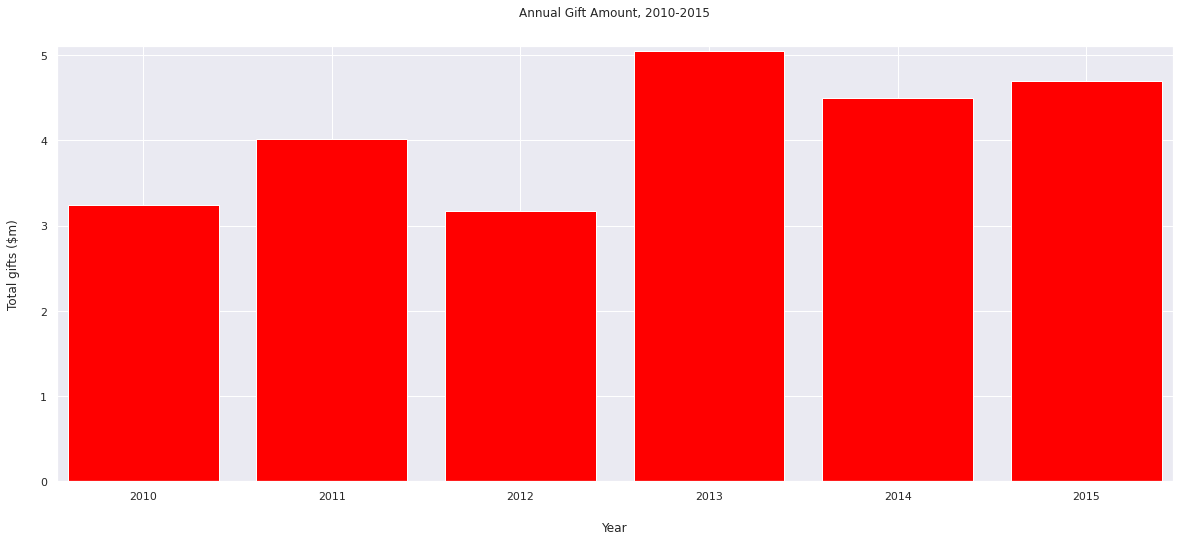

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(x=result["Year"].astype(str), height=result["SUM(Gift_Amount)"] / 1_000_000, color='red')
plt.title("Annual Gift Amount, 2010-2015", pad = 30)
plt.xlabel("Year", labelpad=20)
plt.ylabel("Total gifts ($m)", labelpad=20)
_ = plt.xticks(rotation = 0, ha = "center")
#plt.axhline(result["number_data_points"].mean(), color='blue', linewidth=2, label = "# Countries")
#plt.legend()
plt.margins(0.01, 0.01)

### What is the distribution of gifts?

We looked at the data earlier, so we know there are 3913 unique gift records in the data.

To understand these gifts at a basic level, we can look at the distribution of gifts among different gift amounts. 

By bucketing the gifts in this way, it is clear that the vast majority of gifts are below \$10k, with only a small percentage above \$20k.

In [ ]:
result = pd.read_sql("""SELECT
                    COUNT(CASE WHEN Gift_Amount <= 5000 THEN 1 END) AS [Less Than $5k],
                    COUNT(CASE WHEN Gift_Amount > 5000 AND Gift_Amount <= 10000 THEN 1 END) AS [$5k-$10k],
                    COUNT(CASE WHEN Gift_Amount > 10000 AND Gift_Amount <= 20000 THEN 1 END) AS [$10k-$20k],
                    COUNT(CASE WHEN Gift_Amount > 20000 AND Gift_Amount <= 30000 THEN 1 END) AS [$20k-$30k],
                    COUNT(CASE WHEN Gift_Amount > 30000 AND Gift_Amount <= 40000 THEN 1 END) AS [$30k-$40k],
                    COUNT(CASE WHEN Gift_Amount > 40000 AND Gift_Amount <= 50000 THEN 1 END) AS [$40k-$50k],
                    COUNT(CASE WHEN Gift_Amount > 50000 AND Gift_Amount <= 100000 THEN 1 END) AS [$50k-$100k],
                    COUNT(CASE WHEN Gift_Amount > 100000 AND Gift_Amount <= 200000 THEN 1 END) AS [$100k-$200k],
                    COUNT(CASE WHEN Gift_Amount > 200000 AND Gift_Amount <= 300000 THEN 1 END) AS [$200k-$300k],
                    COUNT(CASE WHEN Gift_Amount > 300000 AND Gift_Amount <= 400000 THEN 1 END) AS [$300k-$400k],
                    COUNT(CASE WHEN Gift_Amount > 400000 AND Gift_Amount <= 500000 THEN 1 END) AS [$400k-$500k]
               FROM GiftRecords;""", database)

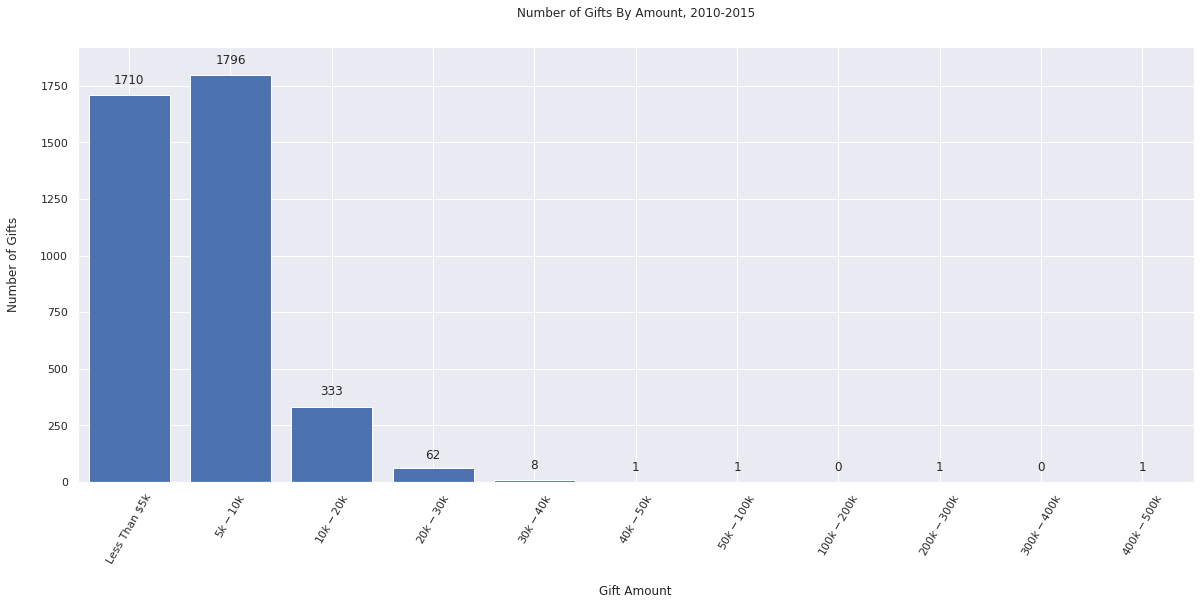

In [ ]:
plt.figure(figsize=(20, 8))
#plt.bar(x=["Less Than $5k",	"$5k-$10k",	"$10k-$20k"], height=[result["Less Than $5k"][0], result["$5k-$10k"][0], result["$10k-$20k"][0]], color='red')
plt.bar(x=result.columns, height = result.iloc[0])
plt.title("Number of Gifts By Amount, 2010-2015", pad = 30)
plt.xlabel("Gift Amount", labelpad=20)
plt.ylabel("Number of Gifts", labelpad=20)
_ = plt.xticks(rotation = 60, ha = "center")
plt.annotate(1710, xy = ("Less Than $5k", 1760), ha='center')
plt.annotate(1796, xy = ("$5k-$10k", 1846), ha='center')
plt.annotate(333, xy = ("$10k-$20k", 383), ha='center')
plt.annotate(62, xy = ("$20k-$30k", 102), ha='center')
plt.annotate(8, xy = ("$30k-$40k", 58), ha='center')
plt.annotate(1, xy = ("$40k-$50k", 51), ha='center')
plt.annotate(1, xy = ("$50k-$100k", 51), ha='center')
plt.annotate(0, xy = ("$100k-$200k", 50), ha='center')
plt.annotate(1, xy = ("$200k-$300k", 51), ha='center')
plt.annotate(0, xy = ("$300k-$400k", 50), ha='center')
plt.annotate(1, xy = ("$400k-$500k", 51), ha='center')
#plt.axhline(result["number_data_points"].mean(), color='blue', linewidth=2, label = "# Countries")
#plt.legend()
plt.margins(0.01, 0.07)

### Most generous donors

Who are the most generous donors and how much have they given?

Based on the distribution chart, we know that two donors in particular have been very generous to the university, donating more than \$400,000 and $200,000 respectively in single gifts.

A larger number of donors have also given amounts between \$20,000 and $100,000.

But who made the largest cumulative donations in the period 2010-2015?

In [ ]:
result = pd.read_sql("""With total_donations As (Select Sum(Gift_Amount) as total_donations
                                        From GiftRecords)

               Select Distinct(Prospect_ID), SUM(Gift_Amount), total_donations, (SUM(Gift_Amount) / total_donations) AS percentage_of_total
               From GiftRecords
               Join total_donations
               Group By Prospect_ID
               Order By Sum(Gift_Amount) DESC
               Limit 20;""", database)

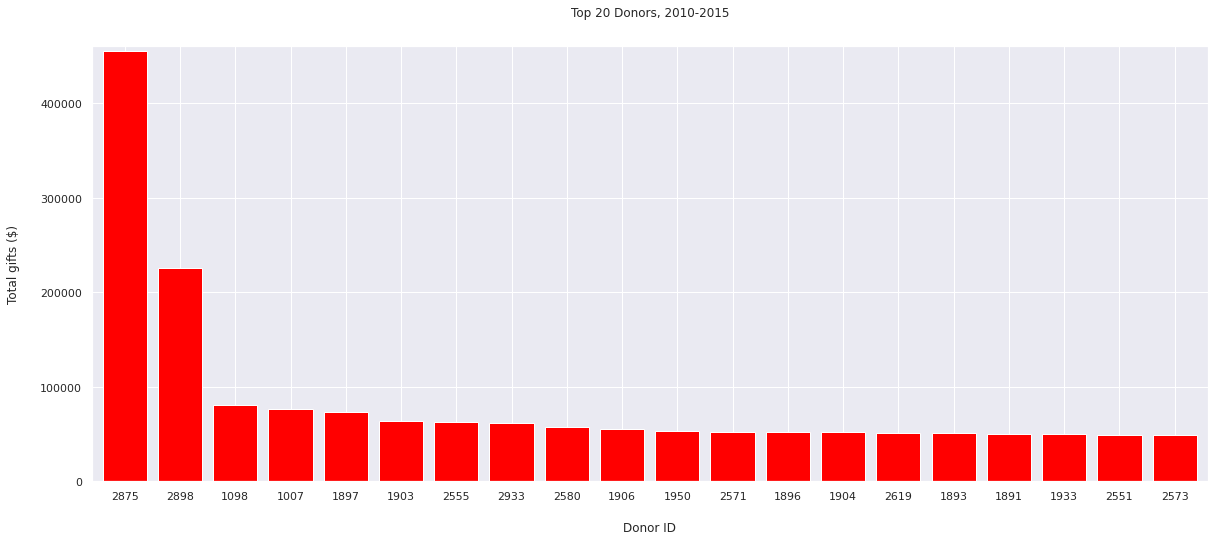

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(x=result["Prospect_ID"].astype(str), height=result["SUM(Gift_Amount)"], color='red')
plt.title("Top 20 Donors, 2010-2015", pad = 30)
plt.xlabel("Donor ID", labelpad=20)
plt.ylabel("Total gifts ($)", labelpad=20)
_ = plt.xticks(rotation = 0, ha = "center")
#plt.axhline(result["number_data_points"].mean(), color='blue', linewidth=2, label = "# Countries")
#plt.legend()
plt.margins(0.01, 0.01)

Who are the top 5 most generous donors each year?

From the chart above, we know who the top overall donors are.

But what does this look like on an annual basis? We can find the top five largest gifts each year to see if there are any patterns. 

In [ ]:
result = pd.read_sql("""SELECT * FROM (SELECT Prospect_ID, 
                      CAST(Gift_Amount AS INT) AS Gift_Amount,
                      substr(Gift_Date, 1, 4) as Year,
                      RANK () OVER (PARTITION BY substr(Gift_Date, 1, 4) ORDER BY Gift_Amount DESC) donor_rank
                      From GiftRecords)
                      WHERE donor_rank <= 5;""", database)

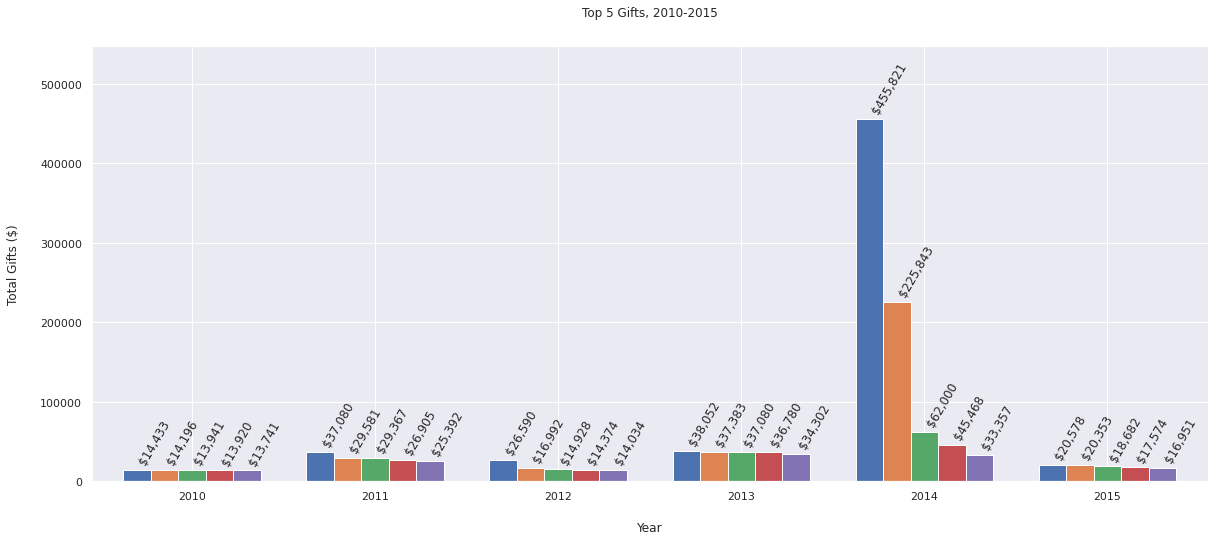

In [ ]:
subset_first = result[result["donor_rank"] == 1]
subset_second = result[result["donor_rank"] == 2]
subset_third = result[result["donor_rank"] == 3]
subset_fourth = result[result["donor_rank"] == 4]
subset_fifth = result[result["donor_rank"] == 5]
#subset_sixth = result[result["donor_rank"] == 6]

x_first = np.arange(len(subset_first["Year"]))
x_second = np.arange(len(subset_second["Year"]))
x_third = np.arange(len(subset_third["Year"]))
x_fourth = np.arange(len(subset_fourth["Year"]))
x_fifth = np.arange(len(subset_fifth["Year"]))
#x_sixth = np.arange(len(subset_sixth["Year"]))

y_first = subset_first["Gift_Amount"]
y_second = subset_second["Gift_Amount"]
y_third = subset_third["Gift_Amount"]
y_fourth = subset_fourth["Gift_Amount"]
y_fifth = subset_fifth["Gift_Amount"]
#y_sixth = subset_sixth["Gift_Amount"]
width = 0.15
fig, ax = plt.subplots(figsize=(20, 8))
rects1 = ax.bar(x_first - 0.3, y_first, width, label="2010")
rects2 = ax.bar(x_second - 0.15, y_second, width, label="2011")
rects3 = ax.bar(x_third + 0.0, y_third, width, label="2012")
rects4 = ax.bar(x_fourth + 0.15, y_fourth, width, label="2013")
rects5 = ax.bar(x_fifth + 0.3, y_fifth, width, label="2014")
#rects6 = ax.bar(x_sixth + 1.05, y_sixth, width, label="2015")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Gifts ($)')
ax.yaxis.labelpad = 20
ax.set_xlabel("Year")

x = np.arange(len(result["Year"]))  # the label locations

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate("${:,}".format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='left', va='bottom', rotation = 60)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)

ax.set_title('Top 5 Gifts, 2010-2015', pad=30)
ax.set_xticks(x_first)
ax.set_xticklabels(subset_first["Year"])
ax.xaxis.labelpad = 20
#ax.legend()
_ = plt.xticks(rotation = 0, ha = "center")
plt.margins(0.03, 0.2)
plt.show()

Running total of gifts (highest to lowest value).

In [ ]:
result = pd.read_sql("""WITH Sum_Total_Gifts AS (SELECT SUM(Gift_Amount) AS Sum_Total_Gifts FROM GiftRecords)

                        SELECT Prospect_ID, Gift_Amount, Sum_Total_Gifts,
                        SUM(Gift_Amount) OVER (ORDER BY Gift_Amount DESC ROWS BETWEEN unbounded preceding and current row) As running_total
                        From GiftRecords
                        JOIN Sum_Total_Gifts
                        GROUP BY Gift_Amount
                        Order By Gift_Amount DESC
                        LIMIT 20;""", database)
result

,Prospect_ID,Gift_Amount,Sum_Total_Gifts,running_total
0,2875,"455,821.00","24,672,757.00","455,821.00"
1,2898,"225,843.00","24,672,757.00","681,664.00"
2,2933,"62,000.00","24,672,757.00","743,664.00"
3,2953,"45,468.00","24,672,757.00","789,132.00"
4,2619,"38,052.00","24,672,757.00","827,184.00"
5,2571,"37,383.00","24,672,757.00","864,567.00"
6,1852,"37,080.00","24,672,757.00","901,647.00"
7,2580,"36,780.00","24,672,757.00","938,427.00"
8,2555,"34,302.00","24,672,757.00","972,729.00"
9,2573,"34,047.00","24,672,757.00","1,006,776.00"


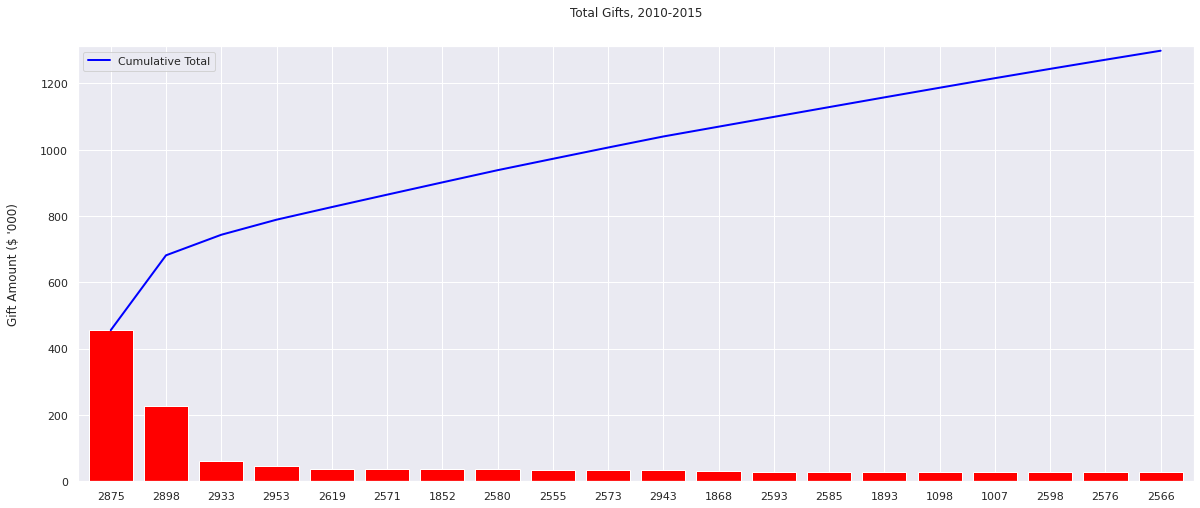

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(x=result["Prospect_ID"].astype(str), height=result["Gift_Amount"] / 1_000, color='red')
plt.title("Total Gifts, 2010-2015", pad = 30)
plt.xlabel("", labelpad=20)
plt.ylabel("Gift Amount ($ '000)", labelpad=20)
_ = plt.xticks(rotation = 0, ha = "center")
plt.plot(result["running_total"] / 1_000, color='blue', linewidth=2, label = "Cumulative Total")
plt.legend(loc = "best")
plt.margins(0.01, 0.01)

### Most generous states

In which states were alumni the most generous?

Colorado was the most generous state, sending more than $3m in donations to the university. Montana was the least generous state.

In [ ]:
result = pd.read_sql("""Select State, SUM(Gift_Amount), COUNT(Gift_Amount), SUM(Gift_Amount) / COUNT(Gift_Amount) AS Average_Gift
               From GiftRecords
               Group By State
               Order By SUM(Gift_Amount) DESC;""", database)

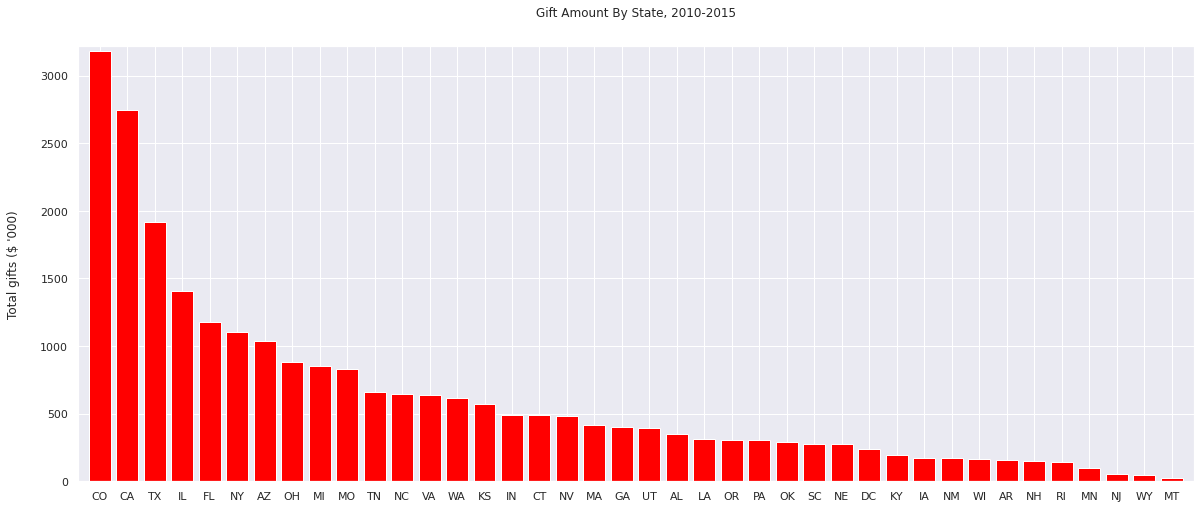

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(x=result["State"].astype(str), height=result["SUM(Gift_Amount)"] / 1_000, color='red')
plt.title("Gift Amount By State, 2010-2015", pad = 30)
#plt.xlabel("City", labelpad=20)
plt.ylabel("Total gifts ($ '000)", labelpad=20)
_ = plt.xticks(rotation = 0, ha = "center")
#plt.axhline(result["number_data_points"].mean(), color='blue', linewidth=2, label = "# Countries")
#plt.legend()
plt.margins(0.01, 0.01)

Let's look at Colorado and Montana in more detail.

Colorado recorded more than 90 times as many gifts as Montana, and an average gift amount that was more than 60% higher than Montana's. The largest gift from a Colorado donor was \$38,052, almost \$30,000 more than the largest gift originating in Montana.

210 individual donors from Colorado made contributions to the univeristy, compared to just 2 from Montana.

In [ ]:
result = pd.read_sql("""SELECT State, 
                               COUNT(Gift_Amount) AS Number_of_Gifts, 
                               MAX(Gift_Amount) Largest_Gift_Amount,
                               AVG(Gift_Amount) Average_Gift_Amount,
                               COUNT(DISTINCT City) Number_of_Cities,
                               COUNT(DISTINCT Prospect_ID) Number_of_Donors
                        From GiftRecords
                        WHERE State = 'CO' OR State = 'MT'
                        Group By State;""", database)
result

,State,Number_of_Gifts,Largest_Gift_Amount,Average_Gift_Amount,Number_of_Cities,Number_of_Donors
0,CO,368,"38,052.00","8,651.94",2,210
1,MT,4,"8,481.00","5,300.50",1,2


### Most generous cities

Colorado was the most generous, and its capital was the most generous city in the dataset.

In [ ]:
result = pd.read_sql("""Select City, SUM(Gift_Amount), COUNT(Gift_Amount), SUM(Gift_Amount) / COUNT(Gift_Amount) AS Average_Gift
               From GiftRecords
               Group By City
               Order By SUM(Gift_Amount) DESC
               Limit 20;""", database)

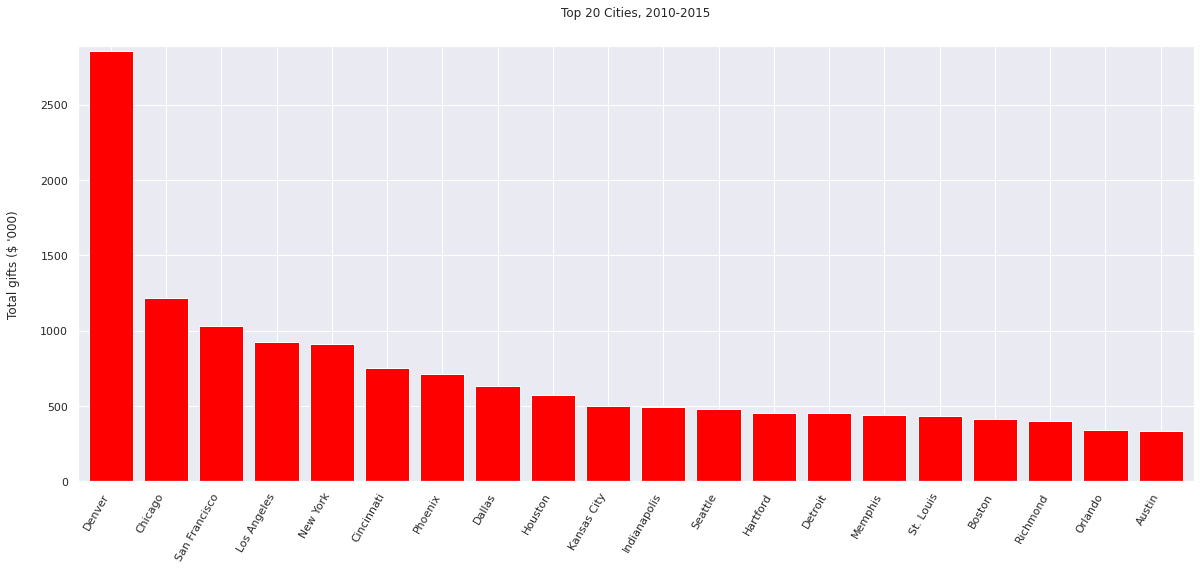

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(x=result["City"].astype(str), height=result["SUM(Gift_Amount)"] / 1_000, color='red')
plt.title("Top 20 Cities, 2010-2015", pad = 30)
#plt.xlabel("City", labelpad=20)
plt.ylabel("Total gifts ($ '000)", labelpad=20)
_ = plt.xticks(rotation = 60, ha = "right")
#plt.axhline(result["number_data_points"].mean(), color='blue', linewidth=2, label = "# Countries")
#plt.legend()
plt.margins(0.01, 0.01)

Let's look at the data for Denver in more detail. We see that Denver accounts for most of the donations from the state of Colorado: 311 of the 368 total gifts, and 181 of the 210 individual donors from Colorado are from Denver.


In [ ]:
result = pd.read_sql("""SELECT City, 
                               COUNT(Gift_Amount) AS Number_of_Gifts, 
                               MAX(Gift_Amount) Largest_Gift_Amount,
                               AVG(Gift_Amount) Average_Gift_Amount,
                               COUNT(DISTINCT City) Number_of_Cities,
                               COUNT(DISTINCT Prospect_ID) Number_of_Donors
                        From GiftRecords
                        WHERE City = 'Denver'
                        Group By City;""", database)
result

,City,Number_of_Gifts,Largest_Gift_Amount,Average_Gift_Amount,Number_of_Cities,Number_of_Donors
0,Denver,311,"38,052.00","9,184.87",1,181


### Most generous majors

Are donors who studied particular majors more likely to donate money to the university after they graduate?

The chart below shows the top 20 most generous majors. Engineers were the most generous donors to the university, followed by Composition and Mathematics graduates.

In [ ]:
result = pd.read_sql("""Select Major, SUM(Gift_Amount), COUNT(Gift_Amount), SUM(Gift_Amount) / COUNT(Gift_Amount) AS Average_Gift
               From GiftRecords
               Group By Major
               Order By SUM(Gift_Amount) DESC
               LIMIT 25;""", database)

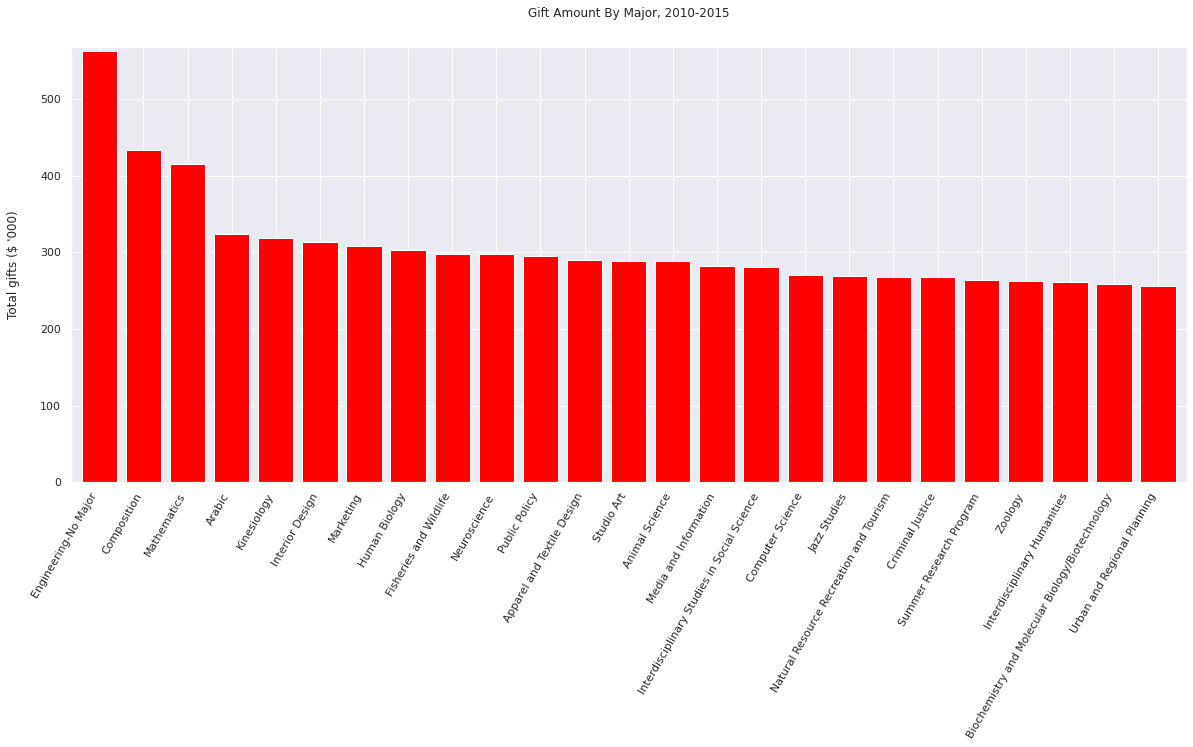

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(x=result["Major"].astype(str), height=result["SUM(Gift_Amount)"] / 1_000, color='red')
plt.title("Gift Amount By Major, 2010-2015", pad = 30)
#plt.xlabel("City", labelpad=20)
plt.ylabel("Total gifts ($ '000)", labelpad=20)
_ = plt.xticks(rotation = 60, ha = "right")
#plt.axhline(result["number_data_points"].mean(), color='blue', linewidth=2, label = "# Countries")
#plt.legend()
plt.margins(0.01, 0.01)

We can take a closer look at the top three most generous majors.

Although Engineering graduates were the most generous overall, fewer Engineering graduates made gifts than did graduates from Composition or Mathematics. Of the three majors, Composition delivered the highest number of gifts and the highest number of individual donors, but the smallest overall and average gift values.

In [ ]:
result = pd.read_sql("""SELECT Major, 
                               COUNT(Gift_Amount) AS Number_of_Gifts, 
                               MAX(Gift_Amount) Largest_Gift_Amount,
                               AVG(Gift_Amount) Average_Gift_Amount,
                               COUNT(DISTINCT Prospect_ID) Number_of_Donors
                        From GiftRecords
                        WHERE Major = 'Engineering-No Major' OR Major = 'Composition' OR Major = 'Mathematics'
                        Group By Major;""", database)
result

,Major,Number_of_Gifts,Largest_Gift_Amount,Average_Gift_Amount,Number_of_Donors
0,Composition,60,"37,080.00","7,234.15",37
1,Engineering-No Major,21,"455,821.00","26,786.60",14
2,Mathematics,32,"225,843.00","12,993.22",18


### Most popular gift allocations

Donors were able to direct their gifts to 25 funds or causes within the university. Where did the donations go?

The two most popular donation destinations were non-subject specific: the Diversity Fund and the University Annual Fund.

The College of Natural Science was the third highest overall recipient of donations, and received more donations than any other university faculty.

In [ ]:
result = pd.read_sql("""Select Allocation_Subcategory, SUM(Gift_Amount), COUNT(Gift_Amount)
               From GiftRecords
               Group By Allocation_Subcategory
               Order By SUM(Gift_Amount) DESC;""", database)

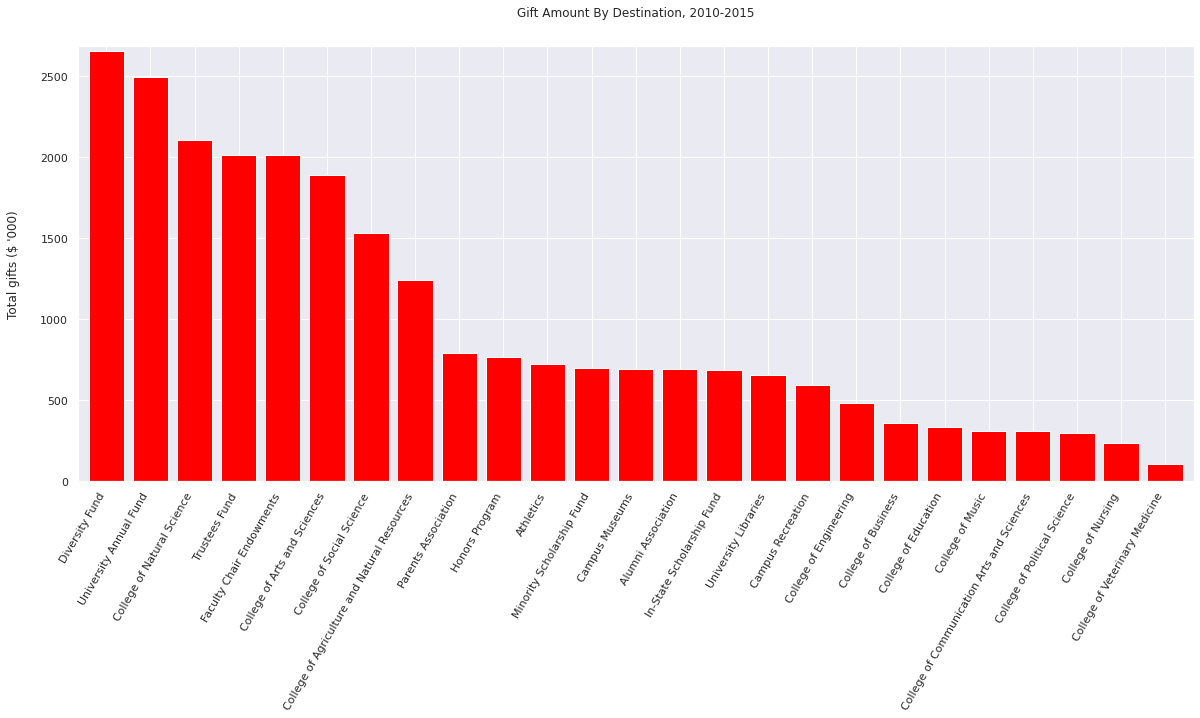

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(x=result["Allocation_Subcategory"].astype(str), height=result["SUM(Gift_Amount)"] / 1_000, color='red')
plt.title("Gift Amount By Destination, 2010-2015", pad = 30)
#plt.xlabel("City", labelpad=20)
plt.ylabel("Total gifts ($ '000)", labelpad=20)
_ = plt.xticks(rotation = 60, ha = "right")
#plt.axhline(result["number_data_points"].mean(), color='blue', linewidth=2, label = "# Countries")
#plt.legend()
plt.margins(0.01, 0.01)

Let's have a look at the donation profiles for the three funds which received the highest number of donations.

Of these three, the University Annual Fund received the highest number of gifts from the highest number of individual donors. However, this fund had the lowest average gift. 

We might assume that the Diversity Fund and the University Annual Fund would attract a more diverse group of donors in terms of the subjects they studied. However, the College of Natural Science had donors from all 12 colleges in the university, as did the other two funds, and had donors from only eight fewer majors than the general funds. 

In [ ]:
result = pd.read_sql("""SELECT Allocation_Subcategory, 
                               COUNT(Gift_Amount) AS Number_of_Gifts, 
                               SUM(Gift_Amount) AS Total_Gift_Amount,
                               MAX(Gift_Amount) AS Largest_Gift_Amount,
                               AVG(Gift_Amount) AS Average_Gift_Amount,
                               COUNT(DISTINCT Prospect_ID) AS Number_of_Donors,
                               COUNT(DISTINCT College) AS Number_of_Colleges,
                               COUNT(DISTINCT Major) AS Number_of_Majors
                        From GiftRecords
                        WHERE Allocation_Subcategory = 'Diversity Fund' OR Allocation_Subcategory = 'University Annual Fund' OR Allocation_Subcategory = 'College of Natural Science'
                        Group By Allocation_Subcategory;""", database)
result

,Allocation_Subcategory,Number_of_Gifts,Total_Gift_Amount,Largest_Gift_Amount,Average_Gift_Amount,Number_of_Donors,Number_of_Colleges,Number_of_Majors
0,College of Natural Science,308,"2,106,294.00","225,843.00","6,838.62",280,12,105
1,Diversity Fund,351,"2,656,506.50","455,821.00","7,568.39",335,12,113
2,University Annual Fund,383,"2,492,738.00","29,538.00","6,508.45",355,12,113


### When are graduates most generous?

The dataset covers donations made between 2010 and 2015 by individuals who graduated from the university between 1960 and 2009.

The first chart shows that, until about 25 years after graduation, graduates get more generous the longer they have been away from the university. 

In [ ]:
result = pd.read_sql("""SELECT (substr(Gift_Date, 1, 4) - Graduation_Year) AS Years_Since_Graduation, 
                               SUM(Gift_Amount),
                               COUNT(Gift_Amount),
                               SUM(Gift_Amount) / COUNT(Gift_Amount) AS Average_Gift
                        FROM GiftRecords 
                        LEFT JOIN GraduationYear On GiftRecords.Prospect_ID = GraduationYear.Prospect_ID
                        GROUP BY Years_Since_Graduation;""", database)

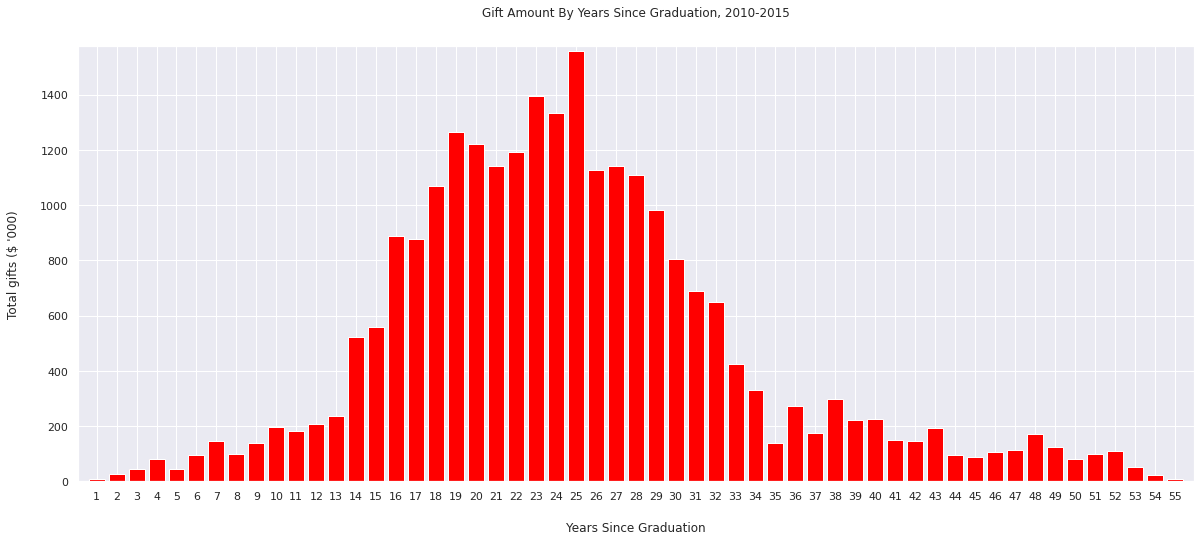

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(x=result["Years_Since_Graduation"].astype(str), height=result["SUM(Gift_Amount)"] / 1_000, color='red')
plt.title("Gift Amount By Years Since Graduation, 2010-2015", pad = 30)
plt.xlabel("Years Since Graduation", labelpad=20)
plt.ylabel("Total gifts ($ '000)", labelpad=20)
_ = plt.xticks(rotation = 0, ha = "center")
#plt.axhline(result["number_data_points"].mean(), color='blue', linewidth=2, label = "# Countries")
#plt.legend()
plt.margins(0.01, 0.01)

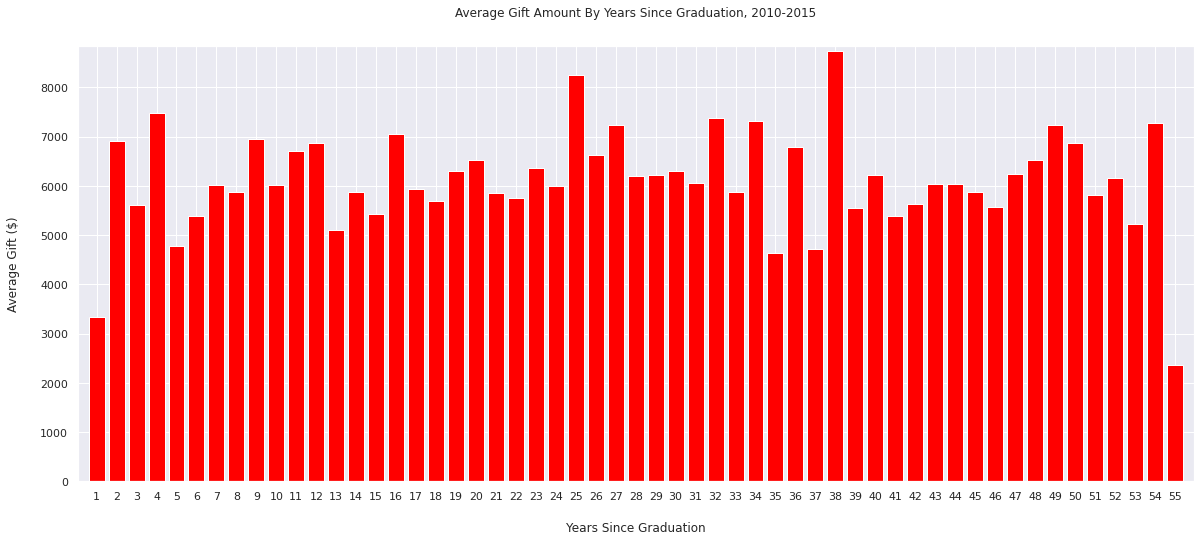

In [90]:
plt.figure(figsize=(20, 8))
plt.bar(x=result["Years_Since_Graduation"].astype(str), height=result["Average_Gift"], color='red')
plt.title("Average Gift Amount By Years Since Graduation, 2010-2015", pad = 30)
plt.xlabel("Years Since Graduation", labelpad=20)
plt.ylabel("Average Gift ($)", labelpad=20)
_ = plt.xticks(rotation = 0, ha = "center")
#plt.legend()
plt.margins(0.01, 0.01)